In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from PIL import Image
import tensorflow.contrib.slim as slim
from scipy import misc
from tensorflow.python.lib import io 
import time as time
from sklearn import preprocessing
import argparse
import collections
import json
import os
import time
import subprocess
import numpy as np
import sys
#from google.cloud.ml import session_bundle
from tensorflow.python.lib.io import file_io
from sklearn import metrics

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.lib.io import file_io
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

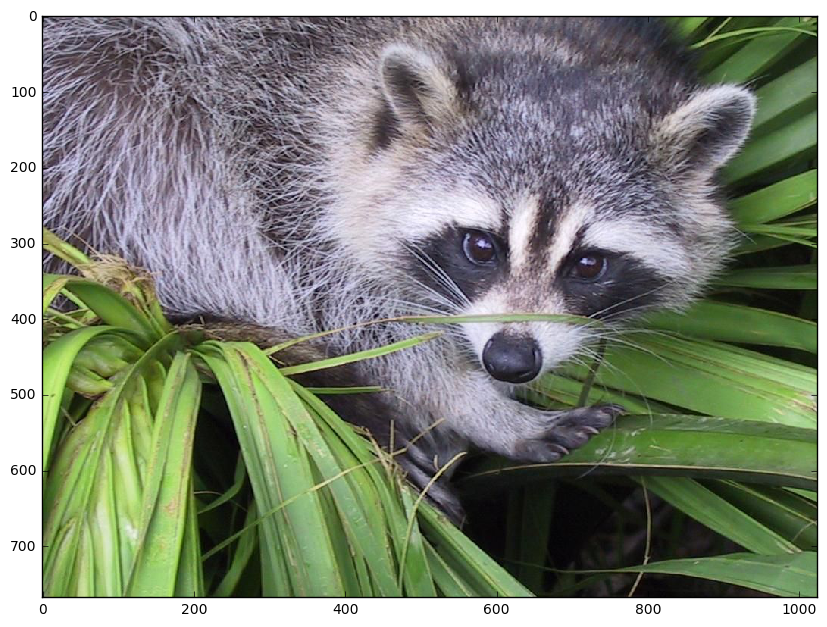

In [4]:
im = misc.face()
plt.imshow(im)

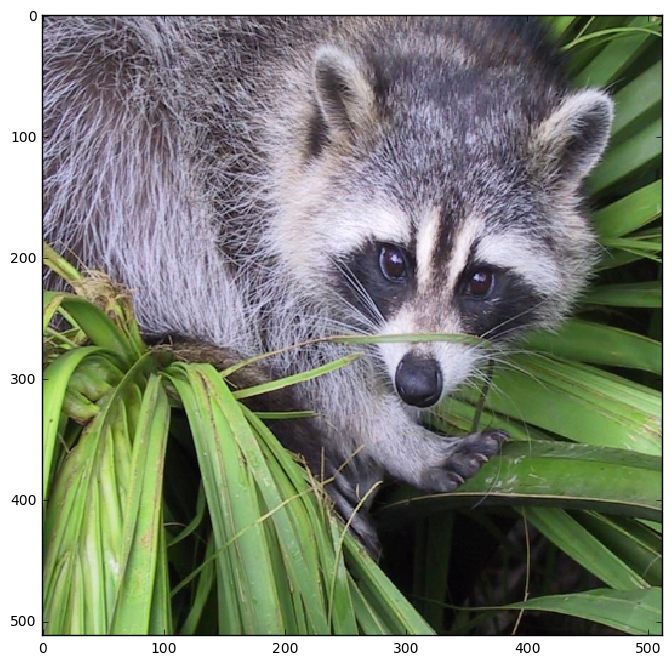

In [5]:
new_im = misc.imresize(im,[512,512])
plt.imshow(new_im)

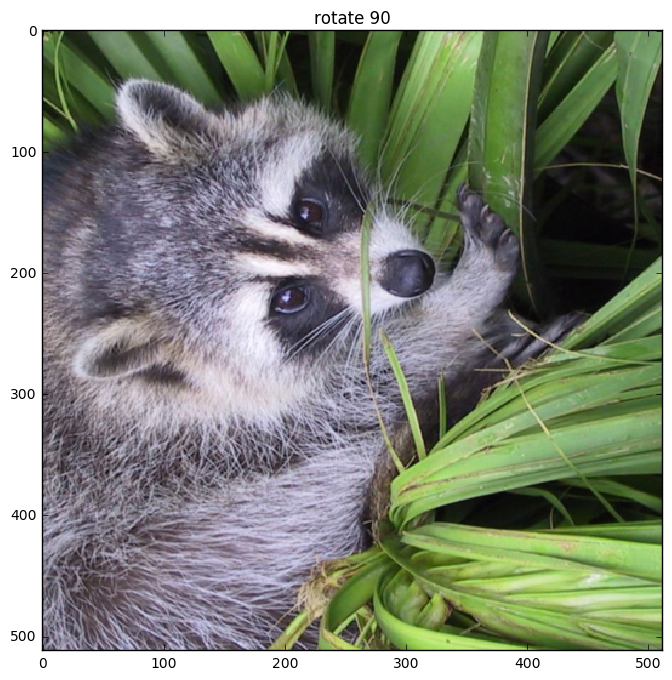

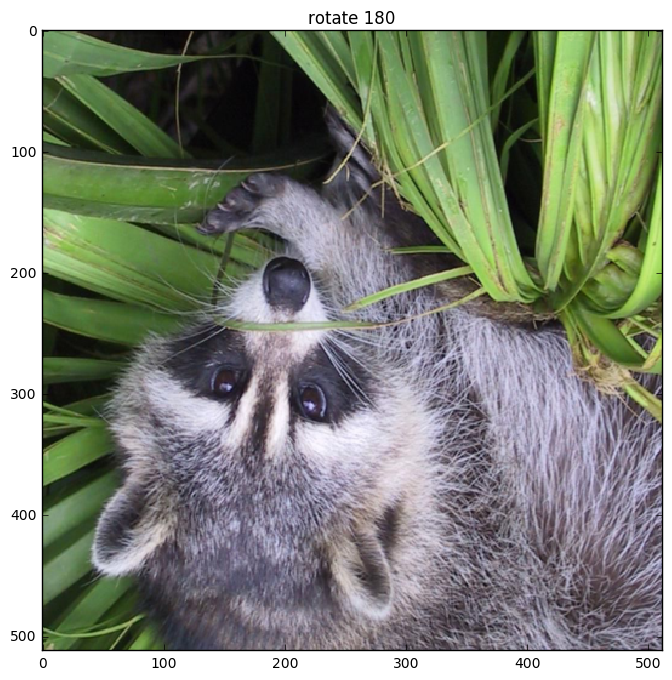

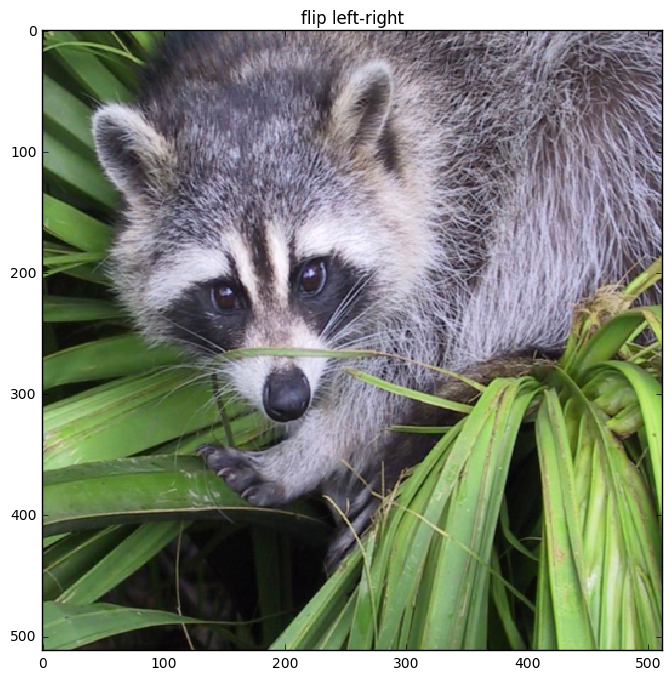

In [9]:
im = misc.imresize(im,[512,512])
new_im = misc.imrotate(im,90)
plt.figure()
plt.imshow(new_im)
plt.title('rotate 90')

new_im = misc.imrotate(im,180)
plt.figure()
plt.imshow(new_im)
plt.title('rotate 180')

new_im = np.fliplr(im)
plt.figure()
plt.imshow(new_im)
plt.title('flip left-right')

In [3]:
"""This is based on:

https://github.com/GoogleCloudPlatform/cloudml-samples/blob/master/mnist/deployable/trainer/task.py
It includes support for training and prediction on the Google Cloud ML service.
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from PIL import Image
import tensorflow.contrib.slim as slim
from scipy import misc
from tensorflow.python.lib import io 
import time as time
from sklearn import preprocessing
import argparse
import collections
import json
import os
import time
import subprocess
import numpy as np
import sys
#from google.cloud.ml import session_bundle
from tensorflow.python.lib.io import file_io
from sklearn import metrics

from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.lib.io import file_io


# Basic model parameters as external flags.
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_integer('max_steps', 20001, 'Number of steps to run trainer.')
flags.DEFINE_integer('batch_size', 24, 'Batch size.')
flags.DEFINE_integer('im_size', 512, 'Batch size.')
flags.DEFINE_string('train_data_dir', '/home/ADH/masked_image_512', 'Directory containing training data')
flags.DEFINE_string('train_test_lists_dir','/home/lun5/ADH/train_test_lists', 'Directory containing list of train/val/test')
flags.DEFINE_string('model_dir', '/home/lun5/ADH/tensorflow/alexnet/model', 'Directory to put the model into.')
flags.DEFINE_string('train_output_dir', '/home/lun5/ADH/tensorflow/alexnet/data', 'Directory containing output data')
#flags.DEFINE_string('train_output_dir', '/home/lun5/tissue-db/tensorflow/alexnet/data', 'Directory containing output data')
# Feel free to add additional flags to assist in setting hyper parameters
flags.DEFINE_float('L2reg',0.0005 , 'L2 regularization for weights')
flags.DEFINE_float('Adam_lr',1e-4, 'Adam optimizer learning rate')
flags.DEFINE_float('Adam_beta1',.9 , 'Adam optimizer beta1')
flags.DEFINE_float('Adam_beta2',.999 , 'Adam optimizer beta2')
flags.DEFINE_float('Adam_eps',1 , 'Adam optimizer epsilon')


labelmap = {'ADH':1,
 'Flat Epithelial':1,
 'Columnar':0,
 'Normal Duct':0
           }

def handle_exception(e):
    print(e)


In [18]:
n_classes = len(set(labelmap.values()))
def read_im_list(fname):
    """
    Read <train_data_dir>/TRAIN which containing paths and labels in
    the format label, channel1 file, channel2 file, channel3 
    Returns:
        List with all filenames in file image_list_file
    """
    image_list_file = FLAGS.train_test_lists_dir + '/' + fname
    f = pd.read_csv(image_list_file)
    filenames = list(f['Image'])
    labels = np.asarray(f['Label'])
    n_classes = len(np.unique(labels))
    labels = [[int(labelmap[l] == 0), int(labelmap[l] == 1)] for l in labels]
    #onehot = [onehot[i] for i in xrange(onehot.shape[0])]
    return zip( labels,filenames)

In [16]:
val_list = read_im_list('tf_val.csv')

In [ ]:
class Fetcher:
    '''Provides batches of images'''
    #TODO TODO - you probably want to modify this to implement data augmentation
    def __init__(self, training_examples):
        #self.current = 0
        training_examples_aug = []
        for label,files in training_examples:
            for i in range(6):
                training_examples_aug.append((label,files,i))
        
        self.examples = training_examples_aug
        labels = [a for a,b,c in self.examples]
        self.current_coded_labels = np.argmax(np.vstack(labels), axis = 1) # keep track of which examples were chosen, -1: chosen
        #self.coded_labels = np.copy(self.current_coded_labels)
            
    
    def load_batch_balanced(self,batchsize):
        #n_classes = len(labelmap)
        num_images_per_class = int(np.floor(batchsize/n_classes))
                
        sample_indices = []
        for i in range(n_classes):
            num_images = np.sum(self.current_coded_labels == i)
            if num_images < 3: # reset
                labels = [a for a,b,c in self.examples]
                self.current_coded_labels = np.argmax(np.vstack(labels), axis = 1)
            sample_indices.append(np.random.choice(
                np.nonzero(self.current_coded_labels == i)[0], size = num_images_per_class, replace = False))
        
        sample_indices = np.hstack(sample_indices)
        self.current_coded_labels[sample_indices] = -1
        x_batch = []
        y_batch = []
        for i in sample_indices:
            label, files, aug_code = self.examples[i]
            label = label.flatten()
            # If you are getting an error reading the image, you probably have
            # the legacy PIL library installed instead of Pillow
            # You need Pillow
            #channels = [ misc.imread(file_io.FileIO(f,'r')) for f in files]
            #channels = misc.imread(file_io.FileIO(files,'r'))
            channels = misc.imread(files)
            #print(channels.shape)
            # resize image to image size
            channels = misc.imresize(channels,[FLAGS.im_size, FLAGS.im_size])
            #try:
            #    
            #except Exception as e:
            #    print('Image %s\n'%(files))
            #    print('shape of channels is ' + channels.shape)
            #    handle_exception(e)
            #    sys.exit()
            # augment image    
            channels = augment_image(channels, aug_code)
            #x_batch.append(np.dstack(channels))
            x_batch.append(channels)
            y_batch.append(label)
            
        return np.array(x_batch), np.array(y_batch)

def augment_image(im, aug_code):
    '''
    0: no augmentation, 1-3: rotation, 4-5: flip
    TODO: 6-8: jitter R, G, B channels
    '''
    if aug_code == 0:
        return im
    elif aug_code == 1:
        im_aug = misc.imrotate(im, 90)
    elif aug_code == 2:
        im_aug = misc.imrotate(im, 180)
    elif aug_code == 3:
        im_aug = misc.imrotate(im, 270)
    elif aug_code == 4:
        im_aug = np.fliplr(im)
    elif aug_code == 5:
        im_aug = np.flipud(im)
    else:
        raise Exception("Wrong augmentation code")

    return im_aug

In [67]:
def network(inputs):
    '''Define the network'''
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
        net = tf.reshape(inputs,[-1,FLAGS.im_size ,FLAGS.im_size,3])
        net = slim.conv2d(net, 32, [3,3], scope='conv1')
        net = slim.max_pool2d(net, [4,4], scope = 'conv1')
        net = slim.conv2d(net,128,[3,3], scope = 'conv2')
        net = slim.max_pool2d(net,[4,4], scope = 'pool2')
        net = slim.flatten(net)
        net = slim.fully_connected(net,64, scope = 'fc')
        net = slim.fully_connected(net, len(labelmap), activation_fn = None, scope = 'output')
    return net

def alexnet(inputs):
    '''Define the network'''
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
        net = tf.reshape(inputs,[-1, FLAGS.im_size,FLAGS.im_size,3])
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool1')
        net = slim.conv2d(net, 192, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool2')
        net = slim.conv2d(net, 384, [3, 3], scope='conv3')
        net = slim.conv2d(net, 384, [3, 3], scope='conv4')
        net = slim.conv2d(net, 256, [3, 3], scope='conv5')
        net = slim.max_pool2d(net, [3, 3], 2, scope='pool5')       
        net = slim.flatten(net)
        net = slim.fully_connected(net,128, scope = 'fc')
        net = slim.fully_connected(net, len(labelmap), activation_fn = None, scope = 'output')
    return net

def overfeat(inputs):
    '''Define the network'''
    with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(0.0, 0.01),
                      weights_regularizer=slim.l2_regularizer(0.0005)):
        net = tf.reshape(inputs,[-1, FLAGS.im_size,FLAGS.im_size,3])
        net = slim.conv2d(net, 64, [11, 11], 4, padding='VALID',
                        scope='conv1')
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool1')
        net = slim.conv2d(net, 256, [5, 5], scope='conv2')
        net = slim.max_pool2d(net, [2, 2], scope='pool2')
        net = slim.conv2d(net,512, [3, 3], scope='conv3')
        net = slim.conv2d(net, 1024, [3, 3], scope='conv4')
        net = slim.conv2d(net, 1024, [3, 3], scope='conv5')
        net = slim.max_pool2d(net, [2, 2], 2, scope='pool5')
        net = slim.flatten(net)
        net = slim.fully_connected(net,64, scope = 'fc')
        net = slim.fully_connected(net,len(labelmap), activation_fn = None, scope = 'output')
    return net

In [40]:
#Read the training data
examples, n_classes = read_training_list() 

In [111]:
def run_training():
    #Read the training data
    examples, n_classes = read_training_list()
    np.random.seed(45) #shuffle the same way each time for consistency
    
    # TODO TODO - implement some sort of cross validation
    # get a validation set
    labels = [a for a,b in examples]
    coded_labels = np.argmax(np.vstack(labels), axis = 1)
    n_classes = len(labelmap)
    num_images_per_class = 30
    val_indices = [np.random.choice(np.nonzero(coded_labels == i)[0],
                                       size = num_images_per_class, replace=False)
                     for i in xrange(n_classes)]    
    val_indices = np.hstack(val_indices)
    val_examples = [examples[i] for i in val_indices]
    
    train_indices = np.delete(np.arange(len(examples)), val_indices)
    training_examples = [examples[i] for i in train_indices]
      
    #np.random.seed(42) #shuffle the same way each time for consistency
    np.random.shuffle(training_examples) 
    
    #fetcher = Fetcher(examples)
    fetcher = Fetcher(training_examples)
    #images, labels = fetcher.load_batch_balanced(FLAGS.batch_size)
    #print images.shape, labels.shape
    file_io.create_dir(os.path.join(FLAGS.model_dir))
    file_io.create_dir(os.path.join(FLAGS.train_output_dir)) 
    #FLAGS.im_size = 256
    with tf.Graph().as_default():
        # Generate placeholders for the images and labels and mark as input.
        x = tf.placeholder(tf.float32, shape=(None, FLAGS.im_size,FLAGS.im_size,3))
        y_ = tf.placeholder(tf.float32, shape=(None, n_classes))

        # See "Using instance keys": https://cloud.google.com/ml/docs/how-tos/preparing-models
        # for why we have keys_placeholder
        keys_placeholder = tf.placeholder(tf.int64, shape=(None,))

        # IMPORTANT: Do not change the input map
        inputs = {'key': keys_placeholder.name, 'image': x.name}
        tf.add_to_collection('inputs', json.dumps(inputs))

        # Build a the network
        #net = network(x)
        net = alexnet(x)
        # Add to the Graph the Ops for loss calculation.
        loss = slim.losses.softmax_cross_entropy(net, y_)
        tf.scalar_summary(loss.op.name, loss)  # keep track of value for TensorBoard

        # To be able to extract the id, we need to add the identity function.
        keys = tf.identity(keys_placeholder)

        # The prediction will be the index in logits with the highest score.
        # We also use a softmax operation to produce a probability distribution
        # over all possible digits.
        # DO NOT REMOVE OR CHANGE VARIABLE NAMES - used when predicting with a model
        prediction = tf.argmax(net, 1)
        scores = tf.nn.softmax(net)

        # Mark the outputs.
        outputs = {'key': keys.name,
                   'prediction': prediction.name,
                   'scores': scores.name}
        tf.add_to_collection('outputs', json.dumps(outputs))

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op = tf.train.AdamOptimizer(FLAGS.Adam_lr).minimize(loss) # lr = 1e-4
        #train_op = tf.train.AdamOptimizer(FLAGS.Adam_lr, beta1 = FLAGS.Adam_beta1, 
        #                                  beta2=FLAGS.Adam_beta2, epsilon=FLAGS.Adam_eps).minimize(loss)

        # Build the summary operation based on the TF collection of Summaries.
        summary_op = tf.merge_all_summaries()

        # Add the variable initializer Op.
        #init = tf.initialize_all_variables()
        init = tf.global_variables_initializer()
        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver(max_to_keep = 20)

        # Create a session for running Ops on the Graph.
        sess = tf.Session()
        # Instantiate a SummaryWriter to output summaries and the Graph.
        summary_writer = tf.train.SummaryWriter(FLAGS.train_output_dir, sess.graph)

        # And then after everything is built:

        # Run the Op to initialize the variables.
        sess.run(init)
        
        lossf = open(os.path.join(FLAGS.model_dir,'loss_acc.txt'),'w')
        lossf.write('step, loss\n')
        lossf.close()
        
        # Start the training loop.
        for step in xrange(FLAGS.max_steps):
            start_time = time.time()
            # Fill a feed dictionary with the actual set of images and labels
            # for this particular training step.
            #images, labels = fetcher.load_batch(FLAGS.batch_size)
            images, labels = fetcher.load_batch_balanced(FLAGS.batch_size)
            # images, labels = load_cv_batch(x_train,y_train,step,FLAGS.batch_size)
            feed_dict = {x: images, y_: labels} 
            # Run one step of the model.  The return values are the activations
            # from the `train_op` (which is discarded) and the `loss` Op.  To
            # inspect the values of your Ops or variables, you may include them
            # in the list passed to sess.run() and the value tensors will be
            # returned in the tuple from the call.
            _, loss_value = sess.run([train_op, loss],
                                   feed_dict=feed_dict)

            duration = time.time() - start_time
            
            # Write the summaries and print an overview fairly often.
            if (step % 5) == 0:
                # Print status to stdout.
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                sys.stdout.flush()
                with open(os.path.join(FLAGS.model_dir,'loss_acc.txt'),'a') as lossf:
                    lossf.write('%d, %g\n' %(step, loss_value) )
                # Update the events file.
                summary_str = sess.run(summary_op, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
            
            if (step%25 == 0 and (step > 1)) or (step == FLAGS.max_steps-1):
                input_alias_map = json.loads(sess.graph.get_collection('inputs')[0])
                output_alias_map = json.loads(sess.graph.get_collection('outputs')[0])
                aliases, tensor_names = zip(*output_alias_map.items())
                y_true = []
                y_pred = []
                for (label, files) in val_examples:
                    #channels = [ misc.imread(file_io.FileIO(f,'r')) for f in files]
                    #channels = [misc.imresize(channels[j],(im_size,im_size)) for j in xrange(len(channels))]
                    channels = misc.imread(files)
                    #channels = misc.imresize(channels,[FLAGS.im_size, FLAGS.im_size])
                    #image = np.dstack(channels) 
                    image = misc.imresize(channels,[FLAGS.im_size, FLAGS.im_size])
                    feed_dict = {input_alias_map['image']: [image]}
                    predict, scores = sess.run(fetches=[output_alias_map['prediction'],
                                                  output_alias_map['scores']], feed_dict=feed_dict)
                    y_true.append(np.argmax(label))
                    y_pred.append(predict[0])

                accuracy = metrics.accuracy_score(y_true,y_pred)
                f1macro = metrics.f1_score(y_true,y_pred,average='macro')
                f1micro = metrics.f1_score(y_true,y_pred,average='micro')
                print('Val Accuracy: %g, Val F1macro: %g, Val F1micro:%g\n' %(accuracy, f1macro, f1micro))
                with open(os.path.join(FLAGS.model_dir,'loss_acc.txt'),'a') as lossf:
                    lossf.write('%d, %g, %g, %g, %g\n' %(step, loss_value, accuracy, f1macro, f1micro))
                
            if ((step%1000 == 0) and (step>1)) or (step == FLAGS.max_steps-1): # and (step > 1):
                # Export the model so that it can be loaded and used later for predictions.
                file_io.create_dir(os.path.join(FLAGS.model_dir, str(step)))
                saver.save(sess, os.path.join(FLAGS.model_dir,  str(step),'export' ))
                           
                #make world readable for submission to evaluation server
                #if FLAGS.model_dir.startswith('gs://'):
                #   subprocess.call(['gsutil', 'acl','ch','-u','AllUsers:R', 
                 #                   os.path.join(FLAGS.model_dir,  str(step))])
            
    
    #You probably want to implement some sort of model evaluation here
    #TODO TODO TODO

In [112]:
run_training()

Step 0: loss = 3.33 (1.884 sec)
Step 5: loss = 3.32 (1.808 sec)
Step 10: loss = 3.27 (1.846 sec)
Step 15: loss = 3.18 (1.819 sec)
Step 20: loss = 3.11 (1.816 sec)
Step 25: loss = 3.13 (1.810 sec)


/home/lun5/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Val Accuracy: 0.0869048, Val F1macro: 0.0369136, Val F1micro:0.0869048

Step 30: loss = 2.97 (2.958 sec)
Step 35: loss = 2.95 (2.999 sec)


KeyboardInterrupt: 

In [29]:
print(FLAGS.im_size)

256
